# <center> Обучение с учителем. Классификация.

## <center> Прогнозирование оттока клиентов банка


## 1.Постановка задачи

Контекст задачи:

> Некоторый банк обратился к нам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее мы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Теперь представители банка предлагают нам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Наша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2.Логистическая регрессия

Для полноты задачи проведём небольшой разведывательный анализ данных. Построим графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 


Text(0.5, 1.0, 'Баланс целевого признака')

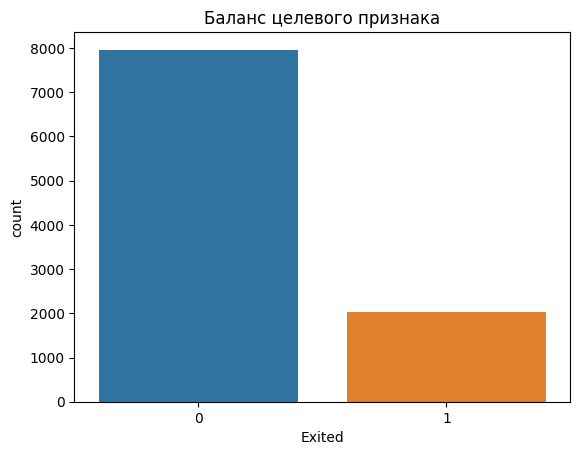

In [3]:
# График распределения целевого признака Exited.
countplot = sns.countplot(data=churn_data,x='Exited')
countplot.set_title('Баланс целевого признака')

Построим тепловую карту корреляции распределния.

<AxesSubplot: >

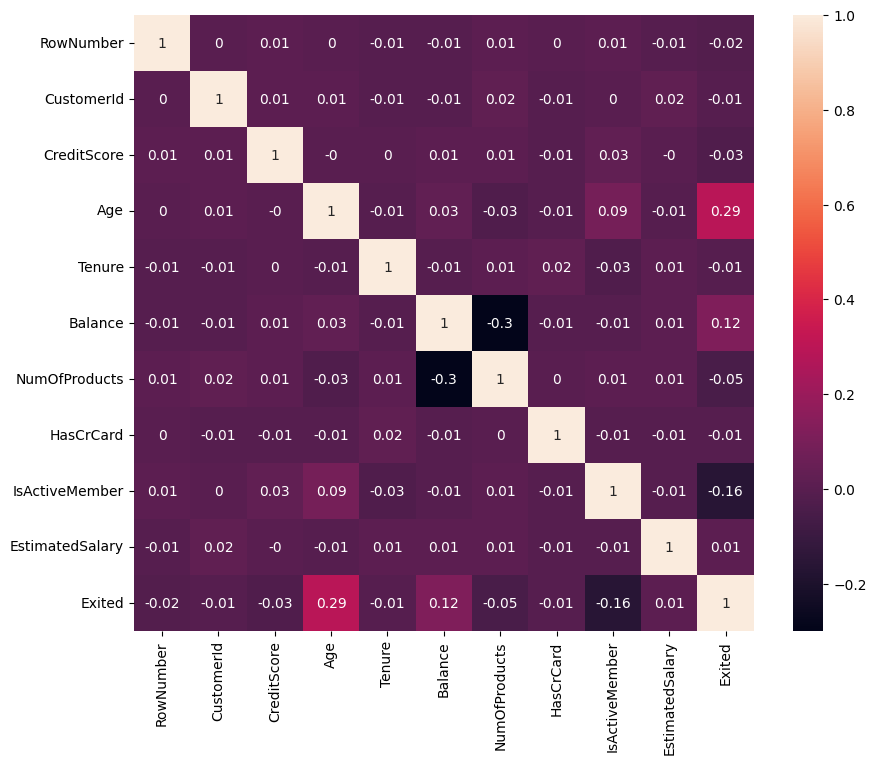

In [4]:
fig,ax = plt.subplots(figsize=(10,8))

# График кореляции 
sns.heatmap(round(churn_data.corr(),2),annot=True)

>Признаки *Age* и *IsActiveMember* самые значимые для целевого признака *Exited*.

Рассмотрим категориальные признаки:

In [5]:
churn_data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Построим графики зависимости целевого признака от категориальных.

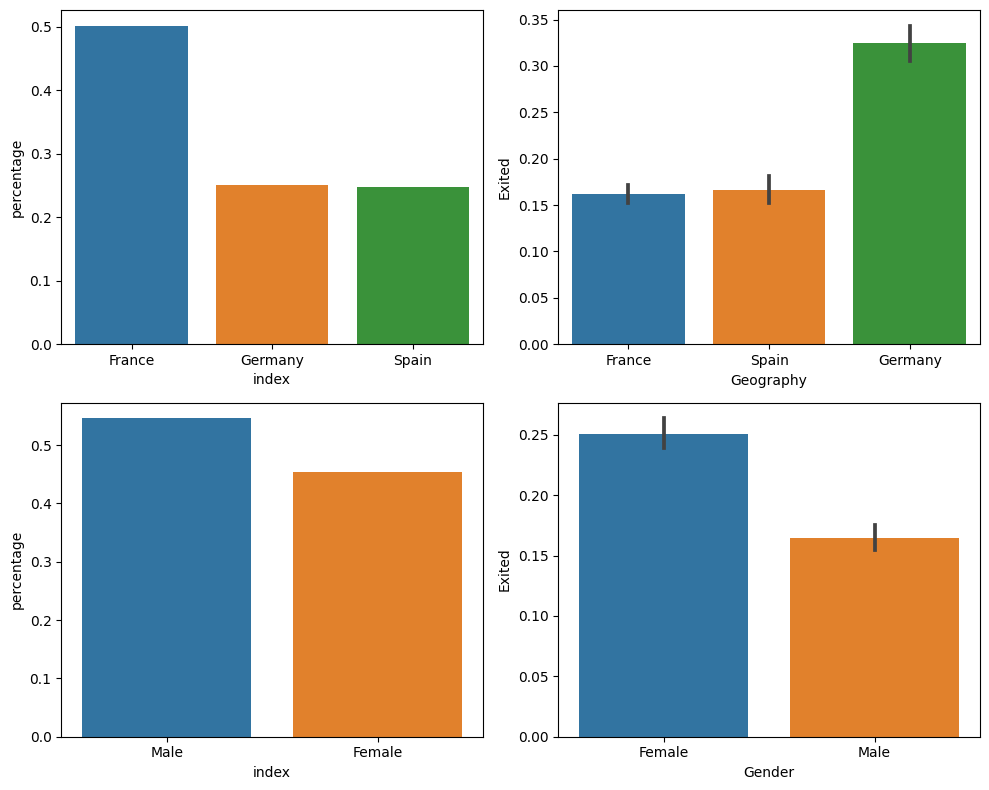

In [6]:
# Объект pd.Series с индексом - название колонок и колонка с названием типов данных. 
dtypes = churn_data.dtypes
# Выделяем список категориальных признаков.
cat_features = dtypes[(dtypes=='object')].index.tolist()
cat_features.remove('Surname')

n=len(cat_features)
fig,ax = plt.subplots(nrows=n,ncols=2,figsize=(10,8))

for i,feature in enumerate(cat_features):
    count_data = (churn_data[feature].value_counts(normalize=True).sort_values(ascending=False).rename('percentage').reset_index())
    count_barplot = sns.barplot(data=count_data,x='index',y='percentage',ax=ax[i][0])
    mean_barplot = sns.barplot(data=churn_data,x=feature,y='Exited',ax=ax[i][1])
    
plt.tight_layout()  # выравнивание графиков

Для признака *'Geography'* и *'Gender'* построены два графика. Первый график показывает процентную долю каждой категории, на втором графике показана доля ушедших клиентов в каждой категории.

>Вывод:
* Больше всего клиентов из Франции, а наибольшее число покинувших банк жители Германии;
* Клиентов мужчин, больше чем женщин, но из числа ушедших из банка женщины занимают первое место.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [7]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [8]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [9]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [10]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### 2.1.Предобработка данных

Для начала расширим датасет с помощью методов *Feature Engineering*. Создадим следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;<br>

* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведем основные статистические характеристики полученных признаков.

In [11]:
# Построим новый признаку BalanceSalaryRatio.
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']

# Построим новый признаку TenureByAge.
churn_data['TenureByAge'] = churn_data['Tenure']/churn_data['Age']

# Построим новый признаку CreditScoreGivenAge.
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/churn_data['Age']

churn_data.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,Female,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,Male,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,Male,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621


Остался один категориальный признак *Gender* закодируем его двоичным кодированием. 

In [12]:
# Кодируем категориальные
import category_encoders as ce

encoder = ce.BinaryEncoder(cols='Gender')
# Кодируем признак двоичным кодированием.
be_gender = encoder.fit_transform(churn_data['Gender'])
churn_data = pd.concat([churn_data, be_gender], axis=1)
# Удаляем признак Gender
churn_data.drop(['Gender'], axis=1, inplace=True)
churn_data.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0,1
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1,0
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1,0


Выведим основные статестические характеристики новых признаков.

In [13]:
churn_data[['BalanceSalaryRatio', 'TenureByAge',
            'CreditScoreGivenAge', 'Gender_0', 'Gender_1']].describe()

,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,9.024870,0.134303,17.526487,0.524512,0.475488
std,214.286020,0.087680,5.349558,0.499498,0.499498
min,0.192582,0.000000,6.112676,0.000000,0.000000
25%,0.783284,0.060606,13.686275,0.000000,0.000000
50%,1.197220,0.125000,16.857143,1.000000,0.000000
75%,2.400083,0.200000,20.852941,1.000000,1.000000
max,10614.655440,0.500000,46.388889,1.000000,1.000000


<AxesSubplot: >

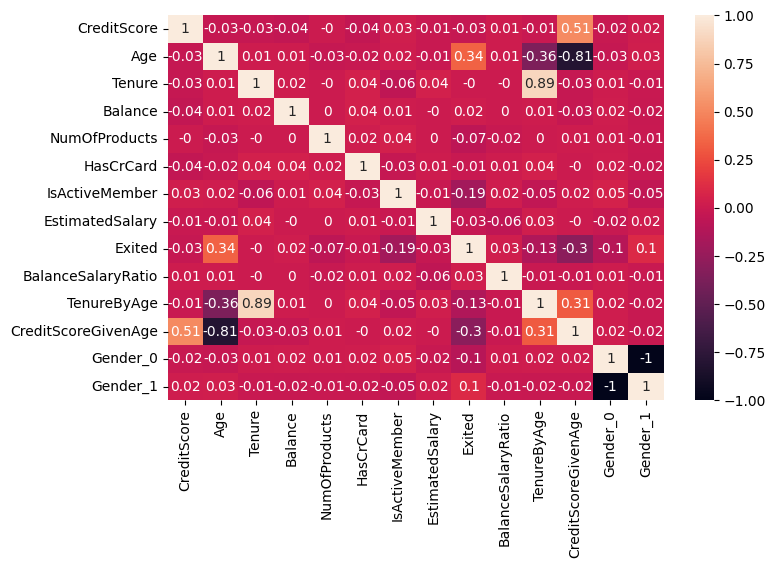

In [14]:
plt.subplots(figsize=(8,5))
sns.heatmap(round(churn_data.corr(),2),annot=True)

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [15]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [16]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [18]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### 2.2.Масштабировании признаков.

Проведём нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберем наиболее подходящий метод.

Обучим один из предложенных скейлеров на тренировочной выборке (вычислим параметры трансформации) и применим трансформацию данных к тренировочной и тестовой выборкам.

Т.к *RobustScaler* изменяет изменяет числовые бинарные признаки в диапазоне $[-1:1]$, а *StandardScaler* изменяет их на числа *float* => проведём нормализацию признаков с помощью *MinMaxScaler*. 

In [19]:
# Выбираем нормализацию.
scaler = preprocessing.MinMaxScaler()
# Вычисляем параметры трансформации.
scaler.fit(X_train)
# Проводим нормализацию тренировочных и тестовых данных.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Теперь переходим к моделированию.

### 2.3.Выбор метрики.

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Для решения даной задачи будем использовать метрику *f1_score*.

>**Обоснование выбора метрики**:
- если было бы нужно сохранить средства кол-центра и предсказать как можно меньше клиентов дизертиров, т.е. снизить ошибку I рода, то мы бы использовать метрику *precision*;
- если было бы нужно сохранить как можно больше клиентов и заранее предсказать их уход, т.е. снизить ошибку II рода, то мы бы использовать метрику *racall*;
- следовательно мы используем метрику *f1_score*, нечто среднее чтобы сохрать средства кол-центра и предсказать число возможных уходов клиентов.



### 2.4.Построение модели *Logistic Regression*

Обучим модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботимся о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделаем предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитаем значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируем полученные результаты, ответив на следующий вопрос:
* Является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительно:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Посмотрим, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

In [20]:
log_reg_l1 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l1',       # тип регуляции
        C=1                 # коэффициент обратный коэффициенту регуляризации
    )
log_reg_l2 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l2',       # тип регуляции
        C=1                 # коэффициент обратный коэффициенту регуляризации
    )
# обучаем модель
log_reg_l1.fit(X_train_scaled, y_train)
log_reg_l2.fit(X_train_scaled, y_train) 

# делаем пердсказание
y_train_predict_l1 = log_reg_l1.predict(X_train_scaled)
y_test_predict_l1 = log_reg_l1.predict(X_test_scaled) 
   
y_train_predict_l2 = log_reg_l2.predict(X_train_scaled)
y_test_predict_l2 = log_reg_l2.predict(X_test_scaled)

# Выводим метрики
print(f'f1_scores_train_l1: {round(metrics.f1_score(y_train,y_train_predict_l1),3)}')
print(f'f1_scores_test_l1: {round(metrics.f1_score(y_test,y_test_predict_l1),3)}\n')

print(f'f1_scores_train_l2: {round(metrics.f1_score(y_train,y_train_predict_l2),3)}')
print(f'f1_scores_test_l2: {round(metrics.f1_score(y_test,y_test_predict_l2),3)}')


f1_scores_train_l1: 0.51
f1_scores_test_l1: 0.419

f1_scores_train_l2: 0.49
f1_scores_test_l2: 0.462


Поэксперементируем с коэфициентом С и выбором типа регуляции между L1 и L2, найдём золотую середину.

In [21]:
# создаём массив чисел 0 до 1.1 с шагом 0.1
x = np.arange(0.1, 2, 0.1)
# округляем значения x их до десятичных
C = [round(i, 2) for i in x]

# Значения метри.
f1_scores_train = []
f1_scores_test = []

for c in C:
    log_reg = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l1',       # тип регуляции
        C=c                 # коэффициент обратный коэффициенту регуляризации
    )
    # обучаем модель
    log_reg.fit(X_train_scaled, y_train) 
    # делаем пердсказание    
    y_train_predict = log_reg.predict(X_train_scaled)
    y_test_predict = log_reg.predict(X_test_scaled)
    
    # добавляем метрику
    f1_scores_train.append(metrics.f1_score(y_train, y_train_predict))
    f1_scores_test.append(metrics.f1_score(y_test, y_test_predict))

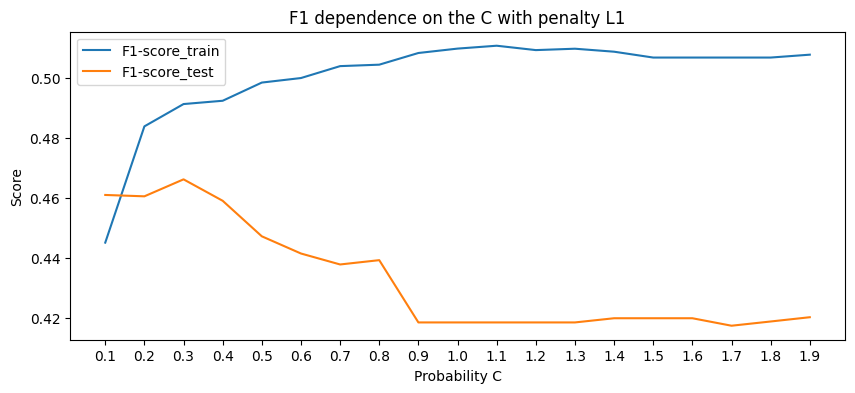

In [22]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1_train от коэффициента C
ax.plot(C, f1_scores_train, label='F1-score_train')
#Строим линейный график зависимости F1_test от коэффициента C
ax.plot(C, f1_scores_test, label='F1-score_test')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the C with penalty L1')
ax.set_xlabel('Probability C')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(C) 
#Отображаем легенду
ax.legend();

In [23]:
# создаём массив чисел 0 до 1.1 с шагом 0.1
x = np.arange(0.1, 2.1, 0.1)
# округляем значения x их до десятичных
C = [round(i, 2) for i in x]

# Значения метри.
f1_scores_train = []
f1_scores_test = []

for c in C:
    log_reg = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l2',       # тип регуляции
        C=c                 # коэффициент обратный коэффициенту регуляризации
    )
    # обучаем модель
    log_reg.fit(X_train_scaled, y_train) 
    # делаем пердсказание    
    y_train_predict = log_reg.predict(X_train_scaled)
    y_test_predict = log_reg.predict(X_test_scaled)
    
    # добавляем метрику
    f1_scores_train.append(metrics.f1_score(y_train, y_train_predict))
    f1_scores_test.append(metrics.f1_score(y_test, y_test_predict))

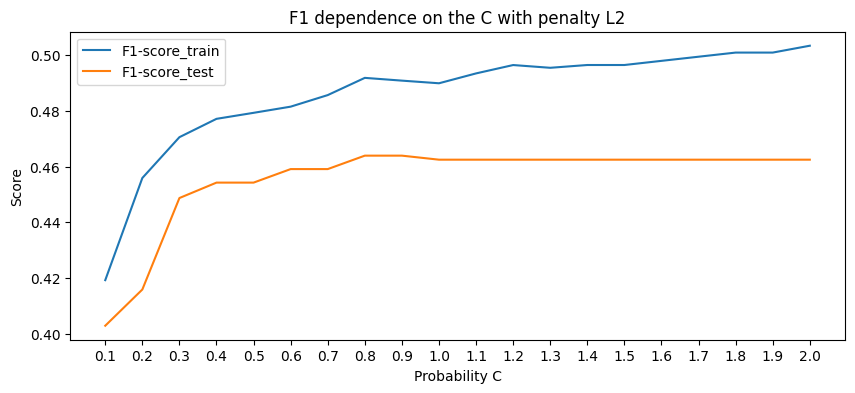

In [24]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1_train от коэффициента C
ax.plot(C, f1_scores_train, label='F1-score_train')
#Строим линейный график зависимости F1_test от коэффициента C
ax.plot(C, f1_scores_test, label='F1-score_test')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the C with penalty L2')
ax.set_xlabel('Probability C')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(C) 
#Отображаем легенду
ax.legend();

In [25]:
log_reg_l1 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l1',       # тип регуляции
        C=0.3                 # коэффициент обратный коэффициенту регуляризации
    )
log_reg_l2 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l2',       # тип регуляции
        C=0.8                 # коэффициент обратный коэффициенту регуляризации
    )
# обучаем модель
log_reg_l1.fit(X_train_scaled, y_train)
log_reg_l2.fit(X_train_scaled, y_train) 

# делаем пердсказание
y_train_predict_l1 = log_reg_l1.predict(X_train_scaled)
y_test_predict_l1 = log_reg_l1.predict(X_test_scaled) 
   
y_train_predict_l2 = log_reg_l2.predict(X_train_scaled)
y_test_predict_l2 = log_reg_l2.predict(X_test_scaled)

# Выводим метрики
print(f'f1_scores_train_l1: {round(metrics.f1_score(y_train,y_train_predict_l1),3)}')
print(f'f1_scores_test_l1: {round(metrics.f1_score(y_test,y_test_predict_l1),3)}\n')

print(f'f1_scores_train_l2: {round(metrics.f1_score(y_train,y_train_predict_l2),3)}')
print(f'f1_scores_test_l2: {round(metrics.f1_score(y_test,y_test_predict_l2),3)}')


f1_scores_train_l1: 0.491
f1_scores_test_l1: 0.466

f1_scores_train_l2: 0.492
f1_scores_test_l2: 0.464


Все значения в выводе приведены для тестовых значений, как для основной цели проекта.

>Вывод_5.6: 
- Изменяя коэфициент $С$ с регуляцией $L1$ и $L2$ мы не добились значительных улучшений результата;
- графически можно судить, диапазон значений по метрики *f1_score* варьируется от $0.4-0.6$;
- $L1$ при $С = 1$ было $0.419$, при наилучшем $С = 0.3$ стало $0.466$;
- $L2$ при $С = 1$ было $0.462$, при наилучшем $С = 0.8$ стало $0.464$;
- можно оставить $L2$ и $С = 1$ без изменений по умолчанию.

### 2.5.Полиномиальные признаки.

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [26]:
# Создаём генератор полиномиальных признаков.
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)

# Сгенерируем полиномиальные признаки.
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

#Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(1881, 559)
(628, 559)


Построим модель на новых полиномиальных признаках и посмотрим как это повлияет на результа. Сначало построим модель и расчитаем метрику при L1 и L2 реруляции.

In [27]:
# Построим модель на новых признаках.
# Создаём модель регрессии.
log_reg_l1_poly = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l1',       # тип регуляции
        C=1                 # коэффициент обратный коэффициенту регуляризации
    )
log_reg_l2_poly = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l2',       # тип регуляции
        C=1                 # коэффициент обратный коэффициенту регуляризации
    )
# обучаем модель
log_reg_l1_poly.fit(X_train_scaled_poly, y_train)
log_reg_l2_poly.fit(X_train_scaled_poly, y_train) 

# делаем пердсказание
y_train_predict_l1_poly = log_reg_l1_poly.predict(X_train_scaled_poly)
y_test_predict_l1_poly = log_reg_l1_poly.predict(X_test_scaled_poly) 
   
y_train_predict_l2_poly = log_reg_l2_poly.predict(X_train_scaled_poly)
y_test_predict_l2_poly = log_reg_l2_poly.predict(X_test_scaled_poly)

# Выводим метрики
print(f'f1_scores_train_l1: {round(metrics.f1_score(y_train,y_train_predict_l1_poly),3)}')
print(f'f1_scores_test_l1: {round(metrics.f1_score(y_test,y_test_predict_l1_poly),3)}\n')

print(f'f1_scores_train_l2: {round(metrics.f1_score(y_train,y_train_predict_l2_poly),3)}')
print(f'f1_scores_test_l2: {round(metrics.f1_score(y_test,y_test_predict_l2_poly),3)}')


f1_scores_train_l1: 0.658
f1_scores_test_l1: 0.631

f1_scores_train_l2: 0.659
f1_scores_test_l2: 0.632


Попробуем улучшить модель с помощь изменения $С$ коэффициента.

In [28]:
# создаём массив чисел 0 до 1.1 с шагом 0.1
x = np.arange(0.1, 2, 0.1)
# округляем значения x их до десятичных
C = [round(i, 2) for i in x]

# Значения метрики, в виде словаря, где {ключ[С-коэффициент], значение[значения метрики]}.
f1_scores_train_poly_l1 = dict(zip(C,[0 for x in C]))
f1_scores_test_poly_l1 = dict(zip(C,[0 for x in C]))

for c in C:
    log_reg_poly_l1 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l1',       # тип регуляции
        C=c                 # коэффициент обратный коэффициенту регуляризации
    )
    # обучаем модель
    log_reg_poly_l1.fit(X_train_scaled_poly, y_train) 
    # делаем пердсказание    
    y_train_predict_poly_l1 = log_reg_poly_l1.predict(X_train_scaled_poly)
    y_test_predict_poly_l1 = log_reg_poly_l1.predict(X_test_scaled_poly)
    
    # добавляем метрику
    f1_scores_train_poly_l1[c] = round(metrics.f1_score(y_train, y_train_predict_poly_l1),3)
    f1_scores_test_poly_l1[c] = round(metrics.f1_score(y_test, y_test_predict_poly_l1),3)

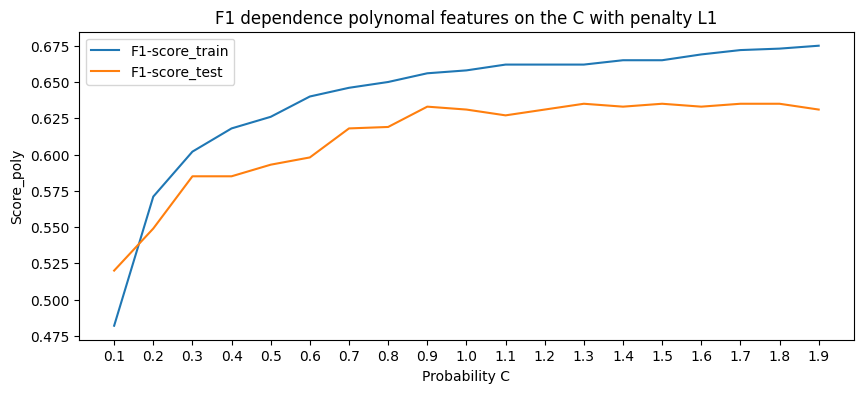

In [29]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1_train от коэффициента C
ax.plot(f1_scores_train_poly_l1.keys(), f1_scores_train_poly_l1.values(), label='F1-score_train')
#Строим линейный график зависимости F1_test от коэффициента C
ax.plot(f1_scores_test_poly_l1.keys(), f1_scores_test_poly_l1.values(), label='F1-score_test')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence polynomal features on the C with penalty L1')
ax.set_xlabel('Probability C')
ax.set_ylabel('Score_poly')
#Устанавливаем отметки по оси x
ax.set_xticks(C) 
#Отображаем легенду
ax.legend();

In [30]:
# создаём массив чисел 0 до 1.1 с шагом 0.1
x = np.arange(0.1, 2, 0.1)
# округляем значения x их до десятичных
C = [round(i, 2) for i in x]

# Значения метрики, в виде словаря, где {ключ[С-коэффициент], значение[значения метрики]}.
f1_scores_train_poly_l2 = dict(zip(C,[0 for x in C]))
f1_scores_test_poly_l2 = dict(zip(C,[0 for x in C]))

for c in C:
    log_reg_poly_l2 = linear_model.LogisticRegression(
        random_state=42,    # генерация случайных чисел
        solver='saga',       # стохастический градиентый спуск
        penalty='l2',       # тип регуляции
        C=c                 # коэффициент обратный коэффициенту регуляризации
    )
    # обучаем модель
    log_reg_poly_l2.fit(X_train_scaled_poly, y_train) 
    # делаем пердсказание    
    y_train_predict_poly_l2 = log_reg_poly_l2.predict(X_train_scaled_poly)
    y_test_predict_poly_l2 = log_reg_poly_l2.predict(X_test_scaled_poly)
    
    # добавляем метрику
    f1_scores_train_poly_l2[c] = round(metrics.f1_score(y_train, y_train_predict_poly_l2),3)
    f1_scores_test_poly_l2[c] = round(metrics.f1_score(y_test, y_test_predict_poly_l2),3)

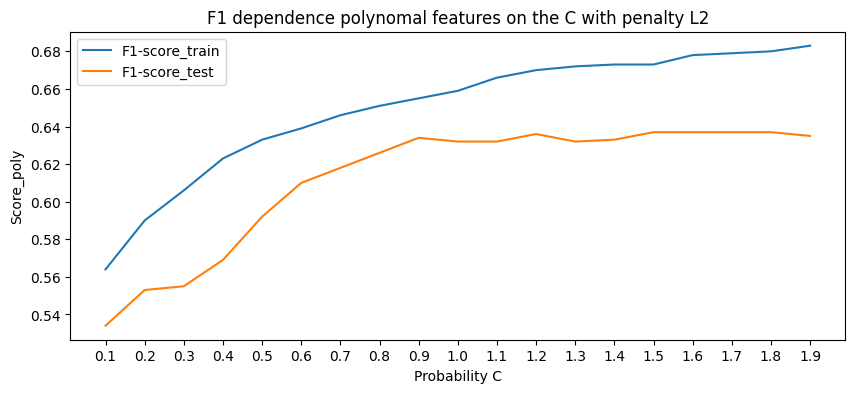

In [31]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1_train от коэффициента C
ax.plot(f1_scores_train_poly_l2.keys(), f1_scores_train_poly_l2.values(), label='F1-score_train')
#Строим линейный график зависимости F1_test от коэффициента C
ax.plot(f1_scores_test_poly_l2.keys(), f1_scores_test_poly_l2.values(), label='F1-score_test')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence polynomal features on the C with penalty L2')
ax.set_xlabel('Probability C')
ax.set_ylabel('Score_poly')
#Устанавливаем отметки по оси x
ax.set_xticks(C) 
#Отображаем легенду
ax.legend();

Определим наилучший коэффициент $C$ для $L1$ и $L2$ регуляции.

In [32]:
# Переименуем для сокращения кода.
l1 = f1_scores_test_poly_l1
l2 = f1_scores_test_poly_l2

# Выводим показания наилучшее С для L1 и L2.
print(f'For L1 best C = {list(l1.keys())[list(l1.values()).index(max(l1.values()))]}, f1_score = {max(l1.values())}')
print(f'For L2 best C = {list(l2.keys())[list(l2.values()).index(max(l2.values()))]}, f1_score = {max(l2.values())}')

For L1 best C = 1.3, f1_score = 0.635
For L2 best C = 1.5, f1_score = 0.637


>**Вывод_5.5:**
- Было $13$ признаков стало $559$, после применения генератора полиномиальных призннаков;
- С новыми полиномиальными признаками модель показала значительно лучше результат, *f1_score* при $С=1$ и $L1$ (было $0.419$ стало $0.631$),при $L2$ (было $0.462$ стало $0.632$)
- Графически можно выделить при $С = 0.9$, что результат при $L1$ и $L2$ регуляции лучше;
- Лучшая метрика в списке полученых значений:
    - For L1 best C = 1.3, f1_score = 0.635
    - For L2 best C = 1.5, f1_score = 0.637
- Далее будем использовать `penalty = l2` и  `C = 1.5`.

### 2.6.Выбор порогового значения (*threshold*)


**Выбор порогового значения принадлежности (thresholds)** к классу $1$ или $0$, по умолчанию $0.5$, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`


Построим график зависимости целевой метрики от порога вероятности. На основе построенного графика определим порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделаем предсказание классов с подобранным оптимальным порогом вероятности. Рассчитаем значение целевой метрики на тестовой выборке и сравним результаты с полученными ранее.


In [33]:
log_reg_poly = linear_model.LogisticRegression(
    random_state=42,    # генерация случайных чисел
    solver='saga',       # стохастический градиентый спуск
    penalty='l2',       # тип регуляции
    C=1.5                 # коэффициент обратный коэффициенту регуляризации
)
# обучаем модель
log_reg_poly.fit(X_train_scaled_poly, y_train) 

LogisticRegression(C=1.5, random_state=42, solver='saga')

In [34]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_train_proba_pred = pd.Series(log_reg_poly.predict_proba(X_train_scaled_poly)[:, 1])
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores_train = []
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_train_pred_poly = y_train_proba_pred.apply(
        lambda x: 1 if x > threshold else 0)
    
    y_test_pred_poly = y_test_proba_pred.apply(
        lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score_train = round(metrics.f1_score(y_train, y_train_pred_poly),3)
    score = round(metrics.f1_score(y_test, y_test_pred_poly),3)
    # Добавляем результат в список
    scores_train.append(score_train)
    scores.append(score)

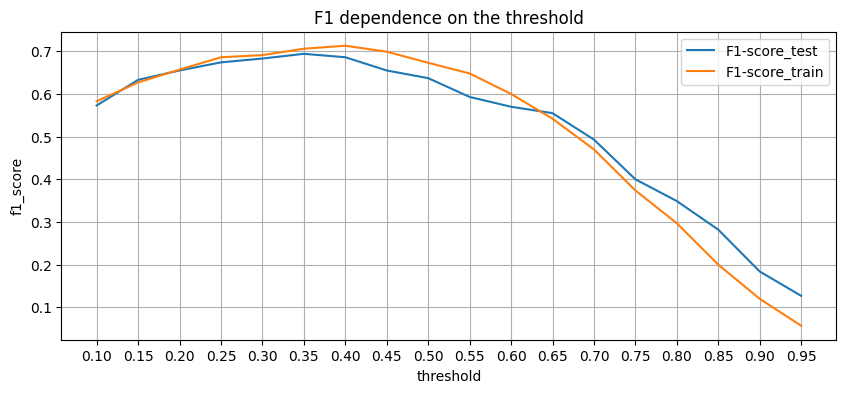

In [35]:
# Визуализируем метрики при различных threshold
fig1, ax1 = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
# Строим линейный график зависимости F1_train от коэффициента C
ax1.plot(thresholds, scores, label='F1-score_test')
ax1.plot(thresholds, scores_train, label='F1-score_train')
# Отображение сетки на графике
ax1.grid(b=True)
# Даём графику название и подписываем оси
ax1.set_title('F1 dependence on the threshold')
ax1.set_xlabel('threshold')
ax1.set_ylabel('f1_score')
# Устанавливаем отметки по оси x
ax1.set_xticks(thresholds) 
# Отображаем легенду
ax1.legend();

Сделаем пердсказание на основе *thresholds* = 0.35, как наилучшевого значения для *f1_score* для тестовых данных.

In [36]:
# Делаем предсказание.
y_train_pred_poly = y_train_proba_pred.apply(
    lambda x: 1 if x > 0.35 else 0)
y_test_pred_poly = y_test_proba_pred.apply(
    lambda x: 1 if x > 0.35 else 0)

f1_score = round(metrics.f1_score(y_test, y_test_pred_poly), 3)

print(f"Best solution: \n\t- penalty = l2; \n\t- C = 1.5; \n\t- thresholds = 0.35; \n\t- f1_score = {f1_score}")

Best solution: 
	- penalty = l2; 
	- C = 1.5; 
	- thresholds = 0.35; 
	- f1_score = 0.694


>**Вывод:**

Благодаря измененю границы (*thresholds* $= 0.35$) определения 1 и 0 (ухода клиентов), получилось улучшить метрику *f1_score* c значения $0.637$ до $0.694$

## 3.Деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [37]:
churn_data.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0,1
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1,0
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1,0


In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Импортируем необходимые библиотеки для построения модели:

In [39]:
from sklearn import tree
from sklearn import ensemble

### 3.1.Модель DecisionTreeClassifier

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботимся о воспроизводимости результатов, установим конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

>Ответим на вопрос:
* Является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


In [40]:
# Создаём модель.
dn_tree = tree.DecisionTreeClassifier(
    criterion='entropy',    # используем энтропию Шенона
    random_state=42         # воспроизводимость результатов
)

# Обучаем модель
dn_tree.fit(X_train, y_train)

# Делаем предсказания.
y_train_predict = dn_tree.predict(X_train)
y_test_predict = dn_tree.predict(X_test)

# Вывод целевой метрики.
print(f'train f1_score: {round(metrics.f1_score(y_train,y_train_predict),2)}')
print(f'test f1_score: {round(metrics.f1_score(y_test,y_test_predict),2)}')

train f1_score: 1.0
test f1_score: 0.56


>Вывод: 
- модель оказалось переобученой, так как предсказание на теренеровочных данных составляет максмум 1.0 (слишком подстроилась, чтобы уловить каждую зависимость), а на тестовых данных всего лишь 0.557.

### 3.2.Модель DecisionTreeClassifier с новыми параметрами

Давайте «подстрижём» наше дерево. 

Обучим на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используем энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботимся о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделаем предсказания для тренировочной и тестовой выборок. Рассчитаем значение целевой метрики на каждой из выборок.

Сравним результат с полученными ранее. Сделаем вывод.


In [41]:
# Создаём модель.
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',    # используем энтропия Шенона  
    max_depth=8,            # глубина дерева
    min_samples_leaf= 10,   # минимальное число наблюдений при делении
    random_state=42,        # повторяемость результатов
    
)

# Обучаем модель
dt_clf.fit(X_train, y_train)

# Делаем предсказания.
y_train_predict = dt_clf.predict(X_train)
y_test_predict = dt_clf.predict(X_test)

# Вывод целевой метрики.
print(f'train f1_score: {round(metrics.f1_score(y_train,y_train_predict),3)}')
print(f'test f1_score: {round(metrics.f1_score(y_test,y_test_predict),3)}')

train f1_score: 0.717
test f1_score: 0.64


>Вывод: 
* Теперь когда мы добавили, параметры *max_depth*(глубину дерева) и *min_samples_leaf*(минимальное число образцов при делении), модель лучше себя показала на тестовых значениях(было $0.56$ стало $0.64$).
* Снизился показатель переобучения, так как разница между метрикой f1_score тринировочных $0.717$ и тестовых $0.64$ данных не велика.

### 3.3.Модель *RandomForestClassifier*

Давайте воспользуемся случайным лесом. 

Построим случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботимся о воспроизводимости результатов, установим конкретное значение значение `random_state` (например, число 42).

Сделаем предсказание для тренировочной и тестовой выборок. Рассчитаем значение целевой метрики на каждой из выборок.

Сравним качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли мы улучшить метрику?


In [42]:
rf_clf = ensemble.RandomForestClassifier(
    criterion='entropy',    # используем энтропия Шенона
    n_estimators=500,       # число случайных деревьев
    max_depth=8,            # максимальная глубина
    min_samples_leaf=10,     # минимальное числ наблюдений
    random_state=42,        # повторяемость результатов
)

# Обучаем модель
rf_clf.fit(X_train, y_train)

# Делаем предсказания.
y_train_predict = rf_clf.predict(X_train)
y_test_predict = rf_clf.predict(X_test)

# Вывод целевой метрики.
print(f'train f1_score: {round(metrics.f1_score(y_train,y_train_predict),3)}')
print(f'test f1_score: {round(metrics.f1_score(y_test,y_test_predict),3)}')

train f1_score: 0.738
test f1_score: 0.637


In [43]:
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1
3827,794,57,3,117056.46,1,1,0,93336.93,1.254128,0.052632,13.929825,1,0
1004,601,26,7,105514.69,2,1,0,50070.59,2.107319,0.269231,23.115385,0,1
2945,835,20,4,124365.42,1,0,0,180197.74,0.690161,0.200000,41.750000,1,0


> Вывод:
* значения train f1_score: 0.738 и test f1_score: 0.637, модель не переобучена.<br>

* применив модель *RandomForestClassifier* для решении задачи, результат метрики, остался практически таким же как и *DecisionTreeClassifier*, где значение *f1_score* было $0.64$ стало $0.637$, будем использовать *DecisionTreeClassifier*.
* это не наилучший подбор параметров, но в целях выполнения задания оставим как есть.

### 3.4.Выбор порогового значения *threshold*

Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Построим график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделаем предсказание классов с подобранным оптимальным порогом вероятности. Рассчитаем значение целевой метрики на тестовой выборке и сравним полученный результат с полученным ранее. 

Напишем небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

In [44]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(dt_clf.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = round(metrics.f1_score(y_test, y_test_pred),2)
    # Добавляем результат в список
    scores.append(score)

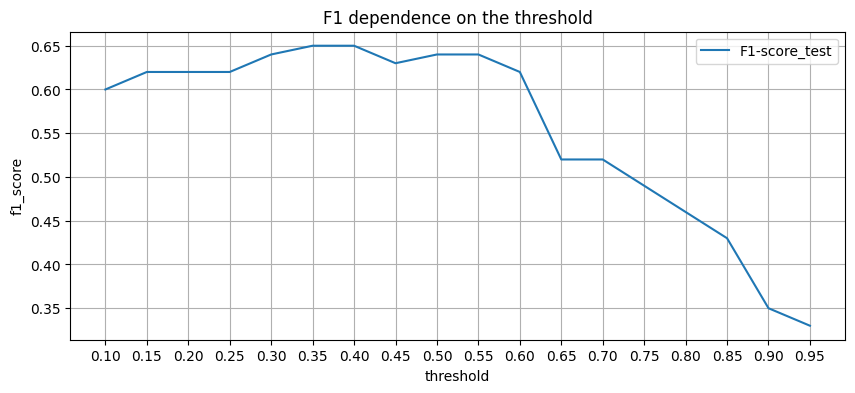

In [45]:
# Визуализируем метрики при различных threshold
fig1, ax1 = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
# Строим линейный график зависимости F1_train от коэффициента C
ax1.plot(thresholds, scores, label='F1-score_test')
# Отображение сетки на графике
ax1.grid(b=True)
# Даём графику название и подписываем оси
ax1.set_title('F1 dependence on the threshold')
ax1.set_xlabel('threshold')
ax1.set_ylabel('f1_score')
# Устанавливаем отметки по оси x
ax1.set_xticks(thresholds) 
# Отображаем легенду
ax1.legend();

На графики видно, что нуилучшим пороговым значением для целевой метрики *f1_score* является $0.35$ или $0.4$. Сделаем предсказание с пороговым значение $0.35$ и расчитем метрику.

In [46]:
# Делаем предсказание.
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > 0.35 else 0)

# Расчитываем метрику.
print('При threshold_0.35 f1_score = {:.3f}'.format(metrics.f1_score(y_test,y_test_pred)))

При threshold_0.35 f1_score = 0.647


> Вывод:
* При *threshold_0.5* f1_score = 0.64, а при *threshold_0.35* *f1_score* = 0.647. Модель *DecisionTreeClassifier* немного лучше стала предсказвать целевой признак.

* Модель *LogisticRegression* показала лучше результат чем *DecisionTreeClassifier* ($0.694$ и $0.647$) на тестовой выборке.

* Остановимся на моделе *LogisticRegression* с полиномиальными признаками.

## Финальная задача

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируем вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

In [47]:
# Преобразуем данные в DataFarame.
client = pd.DataFrame({'CreditScore': [601.0],'Gender': ['Male'],
    'Age': [42.0],'Tenure': [1.0],'Balance': [98495.72],
    'NumOfProducts': [1.0],'HasCrCard': [1.0],'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]})

# Добавляем новые признаки и удаляем не информативные.
client['BalanceSalaryRatio'] = client['Balance']/client['EstimatedSalary']
client['TenureByAge'] = client['Tenure']/client['Age']
client['CreditScoreGivenAge'] = client['CreditScore']/client['Age']
# Создаём признак Gender_0 и Gender_1.
client['Gender_0'] = client['Gender'].apply(lambda x: 1 if x=='Male' else 0)
client['Gender_1'] = client['Gender'].apply(lambda x: 1 if x=='Female' else 0)
# Удаляем признак Gender
client.drop(['Gender'], axis=1, inplace=True)

# Вывод
client

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1
0,601.0,42.0,1.0,98495.72,1.0,1.0,0.0,40014.76,2.461485,0.02381,14.309524,1,0


In [48]:
# Производим нормализацию данных.
ckient_scaled = scaler.transform(client)

# Создаём полиномиальные признаки
client_scaled_poly = poly.transform(ckient_scaled)

# Делаем предсказание с помощю модели LogisticRegression.
client_proba_pred = pd.Series(
    log_reg_poly.predict_proba(client_scaled_poly)[:, 1])
client_pred_poly = client_proba_pred.apply(lambda x: 1 if x > 0.35 else 0)


# Выводим результат.
print(f'Класc клиента: {client_pred_poly.loc[0]}')

if client_pred_poly.loc[0]==1:
    print('Потенциальный клиент ухода из банка, необходимо принять меры.')
else: 
    print('Клиента всё устраивает.')

Класc клиента: 1
Потенциальный клиент ухода из банка, необходимо принять меры.


>Вывод:
* Модель определила, что Василий потенциальный клиент ухода из банка, необходимо принять меры.